In [14]:
import pandas as pd
import numpy as np
import modules.analysis as analysis
import modules.utils as utils
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from importlib import reload
import scipy.stats as stats

In [38]:
# 500, 005
exps = ['experiments/2023020313988255', 'experiments/2022110313584614']
y = []

for exp in exps:
    # load y
    y_ = utils.Experiment.load(exp + '_0')[1]
    y_.name = 'y'
    y_lst = [y_]

    # load y pred
    reps = range(0, 30)
    for rep in reps:
        y_ = pd.concat(utils.Experiment.load(exp + '_' + str(rep))[-1], axis=0)
        y_.name = 'y_pred_' + str(rep)
        y_lst.append(y_)
        
    y.append(pd.concat(y_lst, axis=1))

In [3]:
y_500 = y[0]
y_500['y_pred'] = y_500[[col for col in y_500 if col.startswith('y_pred_')]].mean(axis=1)
y_500 = y_500[['y', 'y_pred']]

y_005 = y[1]
y_005['y_pred'] = y_005[[col for col in y_005 if col.startswith('y_pred_')]].mean(axis=1)
y_005 = y_005[['y', 'y_pred']]

In [4]:
y = pd.concat([y_500, y_005], axis=1)
y.columns = ['y_gt', 'y_pred_500', 'y_005', 'y_pred_005']
y['y_gt'] = y['y_gt'].fillna(y['y_005'])
y = y.drop('y_005', axis=1)
y

y_gt  y_pred_500  y_pred_005
SITE_ID Date                                         
AR-SLu  2010-01-31  10.089000    4.503360    5.145447
        2010-02-28   8.090510    3.766812    4.116378
        2010-03-31   7.076810    2.959408    2.821464
        2010-04-30   5.652600    1.781431    1.356490
        2010-05-31   3.564730    1.123497    1.126939
...                       ...         ...         ...
SE-Svb  2020-08-31   7.760830         NaN    4.217734
        2020-09-30   4.394000         NaN    2.678048
        2020-10-31   1.169280         NaN    1.297358
        2020-11-30   0.254478         NaN    0.759582
        2020-12-31   0.027143         NaN    0.371011

[19019 rows x 3 columns]

In [73]:
df500 = pd.read_csv('analysis/benchmark/2023020313988255/metrics.csv')
df500_mean = df500.mean()

df = pd.read_csv('analysis/benchmark/2022110313584614/metrics.csv')
df_mean = df.mean()

r2_overall_500 = df500_mean.loc['r2_overall']
r2_trend_500 = df500_mean.loc['r2_trend']
r2_anomalies_500 = df500_mean.loc['r2_anomalies']
r2_msc_500 = df500_mean.loc['r2_msc']

print(r2_overall_500, r2_trend_500, r2_anomalies_500, r2_msc_500)

r2_overall_005 = df_mean.loc['r2_overall']
r2_trend_005 = df_mean.loc['r2_trend']
r2_anomalies_005 = df_mean.loc['r2_anomalies']
r2_msc_005 = df_mean.loc['r2_msc']

print(r2_overall_005, r2_trend_005, r2_anomalies_005, r2_msc_005)

0.8163871813133307 0.5338577018556026 0.30912218901583305 0.8722577448445902
0.7452016005197656 0.4774134524034305 0.1030765160062669 0.8141566368155784


In [62]:
reload(analysis)

<module 'modules.analysis' from '/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py'>

In [74]:
# total
y_total = pd.melt(y, id_vars=['y_gt'], value_vars=['y_pred_500', 'y_pred_005'], var_name='Resolution', value_name='Value')

# msc
y_msc = pd.DataFrame({
    'y_gt': analysis.msc(y['y_gt']),
    'y_pred_500': analysis.msc(y['y_pred_500']),
    'y_pred_005': analysis.msc(y['y_pred_005']),
})
y_msc = pd.melt(y_msc, id_vars=['y_gt'], value_vars=['y_pred_500', 'y_pred_005'], var_name='Resolution', value_name='Value')

# trend
y_trend = y[y.notna().all(axis=1)]
y_trend = y_trend[(y_trend['y_gt'].groupby('SITE_ID').transform(lambda x: x.count()) >= 24)]
y_trend = y_trend.apply(analysis.across_site_trend)
y_trend = pd.melt(y_trend, id_vars=['y_gt'], value_vars=['y_pred_500', 'y_pred_005'], var_name='Resolution', value_name='Value')
# multiply with months per year squared
y_trend[['y_gt', 'Value']] = y_trend[['y_gt', 'Value']] * 12**2

# anomalies
y_anomalies = pd.concat([analysis.iav(y['y_gt'], detrend=True), analysis.iav(y['y_pred_500'].dropna(), detrend=True), analysis.iav(y['y_pred_005'].dropna(), detrend=True)], axis=1)
y_anomalies = pd.melt(y_anomalies, id_vars=['y_gt'], value_vars=['y_pred_500', 'y_pred_005'], var_name='Resolution', value_name='Value')

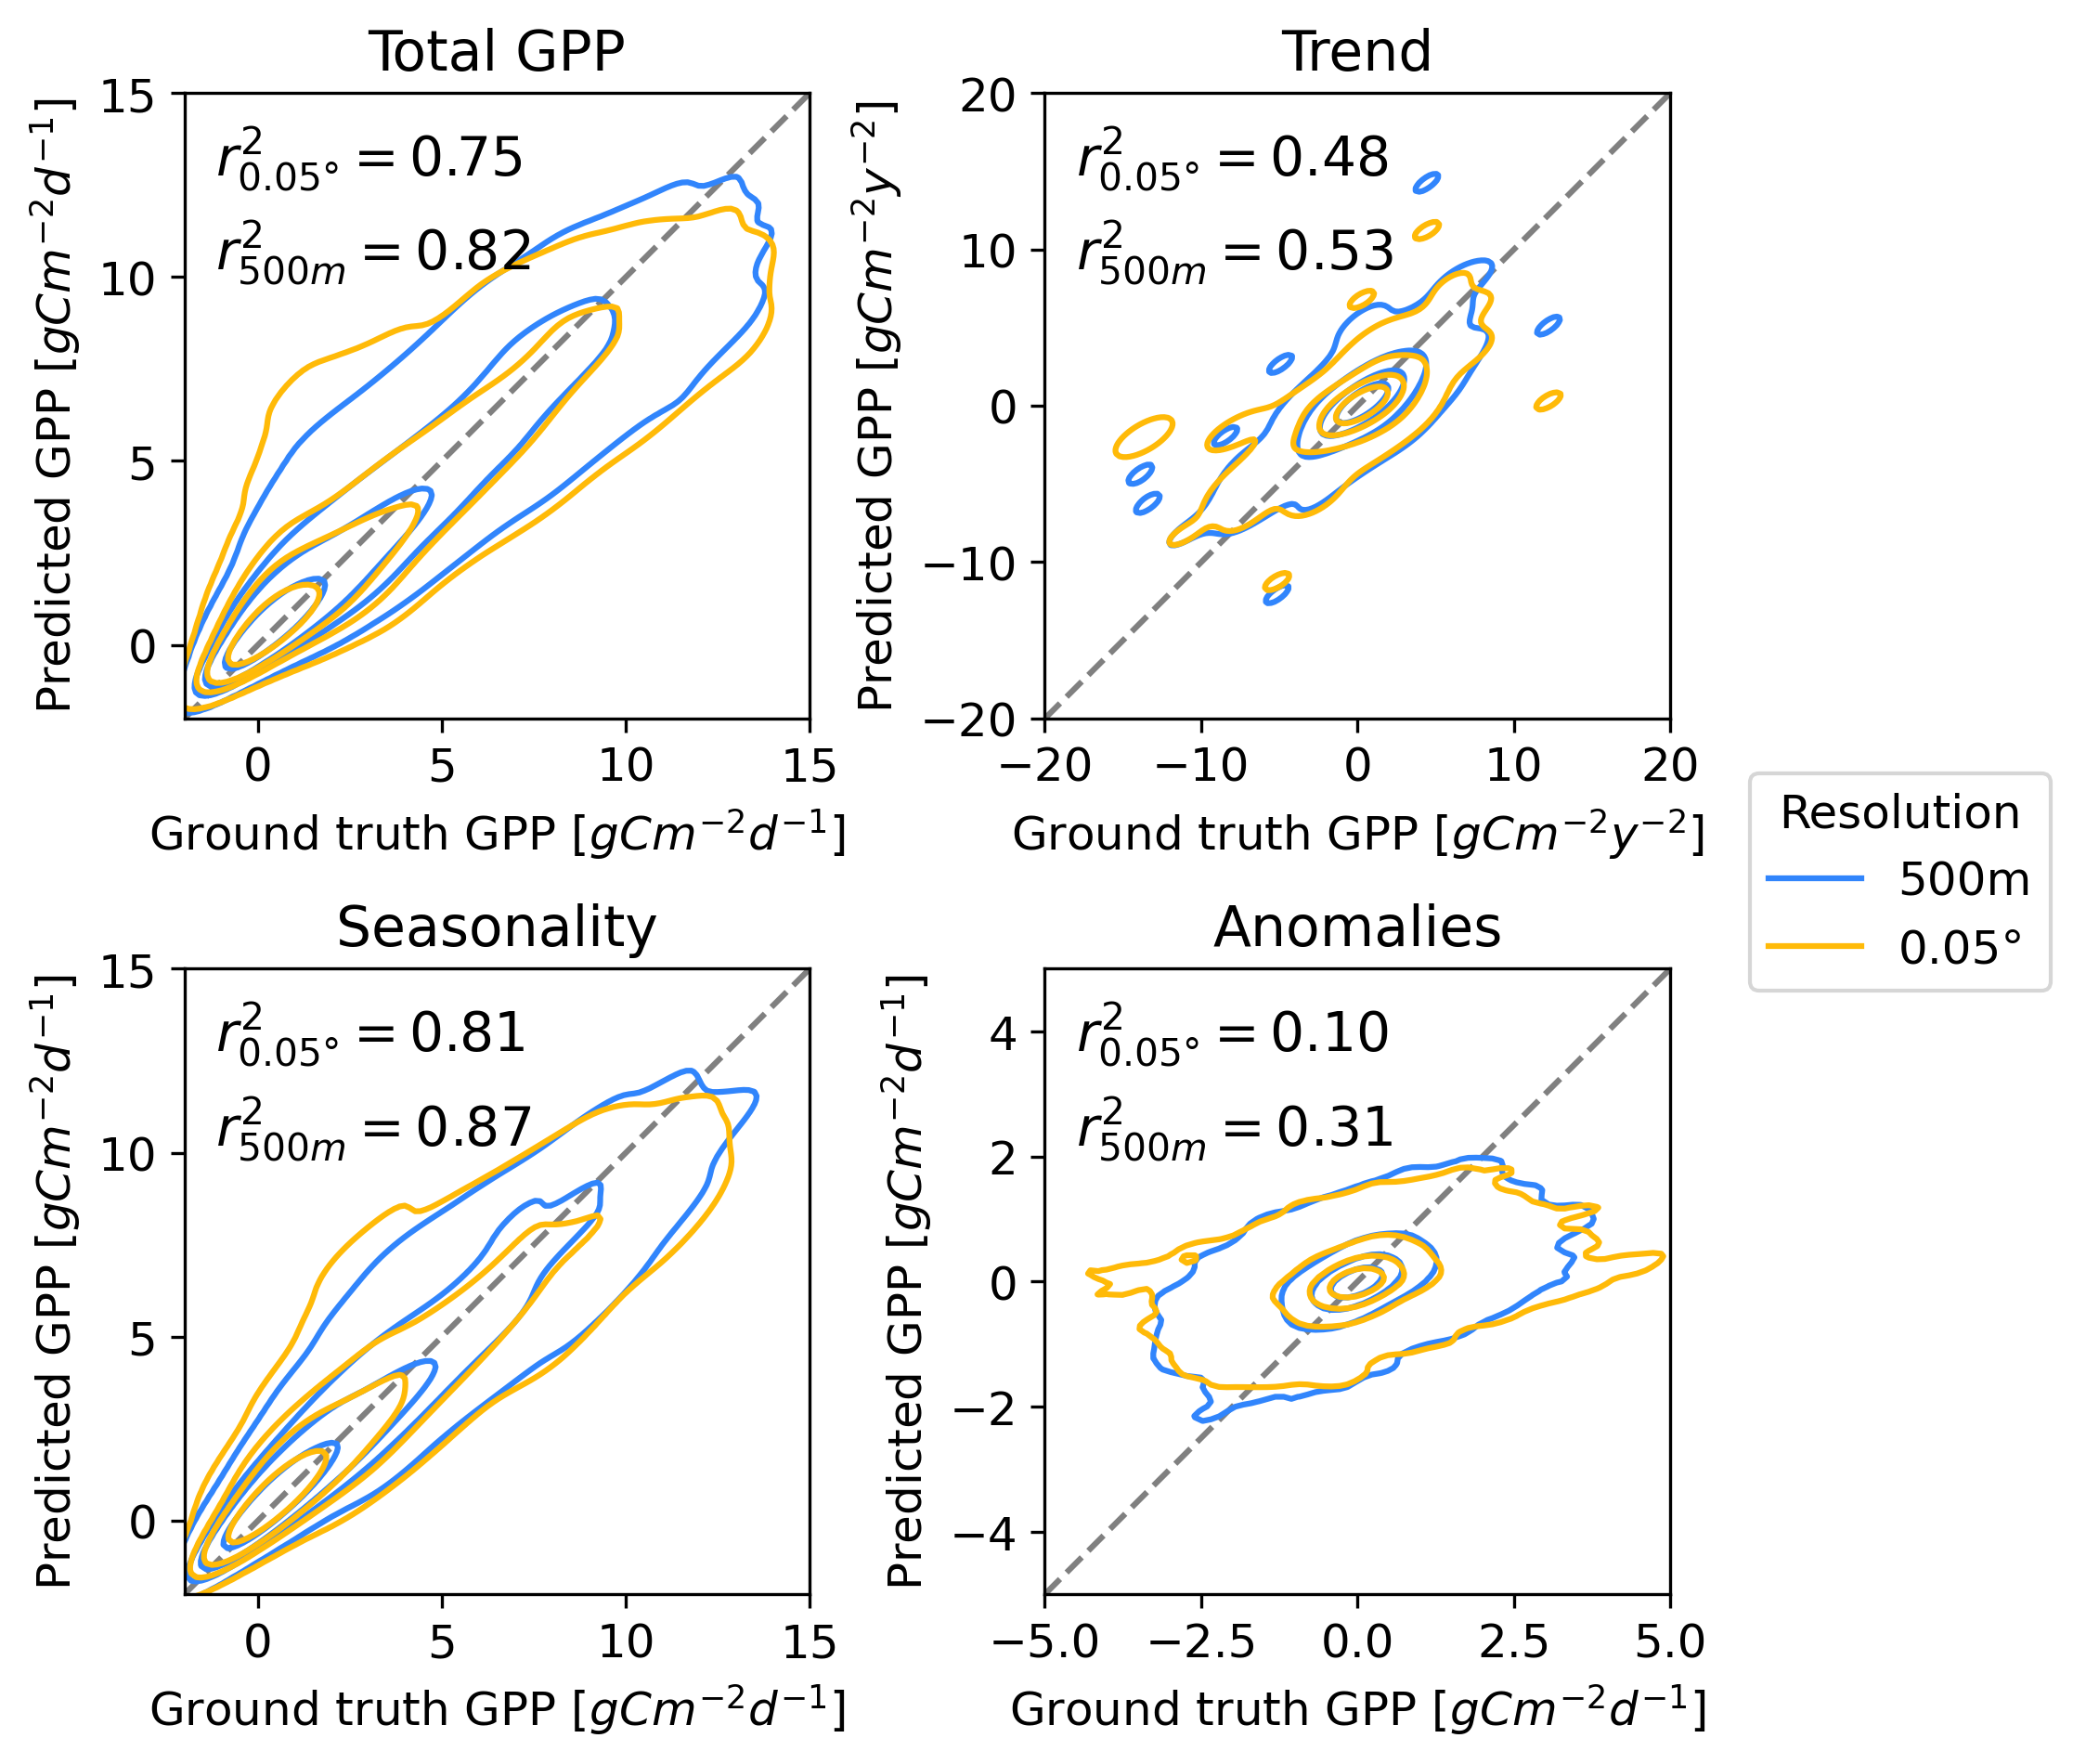

In [76]:
fig, ax = plt.subplots(2, 2, figsize=(8, 7))

ax[0, 0].axline((0, 0), slope=1, color="gray", linestyle='--')
sns.kdeplot(ax=ax[0, 0], data=y_total, x='y_gt', y='Value', hue='Resolution', levels=5)
ax[0, 0].set_xlim((-2, 15))
ax[0, 0].set_ylim((-2, 15))
ax[0, 0].set_xlabel('Ground truth GPP [$gC m^{-2} d^{-1}$]')
ax[0, 0].set_ylabel('Predicted GPP [$gC m^{-2} d^{-1}$]')
ax[0, 0].set_title('Total GPP')
ax[0, 0].text(0.05, 0.95, r'$r^2_{0.05°}=%.2f$' % (r2_overall_005, ), transform=ax[0, 0].transAxes, fontsize=14, verticalalignment='top')
ax[0, 0].text(0.05, 0.8, r'$r^2_{500m}=%.2f$' % (r2_overall_500, ), transform=ax[0, 0].transAxes, fontsize=14, verticalalignment='top')
ax[0, 0].set(adjustable='box', aspect='equal')

handles = ax[0, 0].legend_.legendHandles
ax[0, 0].legend_.remove()

ax[0, 1].axline((0, 0), slope=1, color="gray", linestyle='--')
sns.kdeplot(ax=ax[0, 1], data=y_trend, x='y_gt', y='Value', hue='Resolution', levels=5)
ax[0, 1].set_xlim((-20, 20))
ax[0, 1].set_ylim((-20, 20))
ax[0, 1].set_xlabel('Ground truth GPP [$gC m^{-2} y^{-2}$]')
ax[0, 1].set_ylabel('Predicted GPP [$gC m^{-2} y^{-2}$]')
ax[0, 1].set_title('Trend')
ax[0, 1].text(0.05, 0.95, r'$r^2_{0.05°}=%.2f$' % (r2_trend_005, ), transform=ax[0, 1].transAxes, fontsize=14, verticalalignment='top')
ax[0, 1].text(0.05, 0.8, r'$r^2_{500m}=%.2f$' % (r2_trend_500, ), transform=ax[0, 1].transAxes, fontsize=14, verticalalignment='top')
ax[0, 1].set(adjustable='box', aspect='equal')
ax[0, 1].legend_.remove()

ax[1, 0].axline((0, 0), slope=1, color="gray", linestyle='--')
sns.kdeplot(ax=ax[1, 0], data=y_msc, x='y_gt', y='Value', hue='Resolution', levels=5)
ax[1, 0].set_xlim((-2, 15))
ax[1, 0].set_ylim((-2, 15))
ax[1, 0].set_xlabel('Ground truth GPP [$gC m^{-2} d^{-1}$]')
ax[1, 0].set_ylabel('Predicted GPP [$gC m^{-2} d^{-1}$]')
ax[1, 0].set_title('Seasonality')
ax[1, 0].text(0.05, 0.95, r'$r^2_{0.05°}=%.2f$' % (r2_msc_005, ), transform=ax[1, 0].transAxes, fontsize=14, verticalalignment='top')
ax[1, 0].text(0.05, 0.8, r'$r^2_{500m}=%.2f$' % (r2_msc_500, ), transform=ax[1, 0].transAxes, fontsize=14, verticalalignment='top')
ax[1, 0].set(adjustable='box', aspect='equal')
ax[1, 0].legend_.remove()

ax[1, 1].axline((0, 0), slope=1, color="gray", linestyle='--')
sns.kdeplot(ax=ax[1, 1], data=y_anomalies, x='y_gt', y='Value', hue='Resolution', levels=5)
ax[1, 1].set_xlim((-5, 5))
ax[1, 1].set_ylim((-5, 5))
ax[1, 1].set_xlabel('Ground truth GPP [$gC m^{-2} d^{-1}$]')
ax[1, 1].set_ylabel('Predicted GPP [$gC m^{-2} d^{-1}$]')
ax[1, 1].set_title('Anomalies')
ax[1, 1].text(0.05, 0.95, r'$r^2_{0.05°}=%.2f$' % (r2_anomalies_005, ), transform=ax[1, 1].transAxes, fontsize=14, verticalalignment='top')
ax[1, 1].text(0.05, 0.8, r'$r^2_{500m}=%.2f$' % (r2_anomalies_500, ), transform=ax[1, 1].transAxes, fontsize=14, verticalalignment='top')
ax[1, 1].set(adjustable='box', aspect='equal')
ax[1, 1].legend_.remove()

fig.legend(handles, ['500m', '0.05°'], loc="center right", title='Resolution')
fig.subplots_adjust(right=0.85, wspace=0.14, hspace=0.4)

plt.savefig('analysis/benchmark/benchmark_resolution.pdf')

### Check bias

In [36]:
quantiles = y['y_gt'].quantile([0, .25, .5, .75, 1]).values

grps = []
for idx, quant in enumerate(quantiles[1:]):
    print(quantiles[idx], quant)
    temp = y[(y.y_gt <= quant) & (y.y_gt >= quantiles[idx])]
    grps.append(temp.y_pred_005 - temp.y_gt)

-0.97243 0.40763499999999997
0.40763499999999997 2.27818
2.27818 6.0674399999999995
6.0674399999999995 23.8888


In [37]:
for grp in grps:
    print(stats.wilcoxon(grp))
    print(grp.median())

WilcoxonResult(statistic=754098.0, pvalue=0.0)
0.30911287163896917
WilcoxonResult(statistic=3626227.0, pvalue=9.359165773810124e-102)
0.16757898364737633
WilcoxonResult(statistic=5502695.0, pvalue=0.11070188277524977)
-0.19206477478702855
WilcoxonResult(statistic=2147799.0, pvalue=3.3041398208414966e-300)
-1.212892213220199


<AxesSubplot: ylabel='Frequency'>

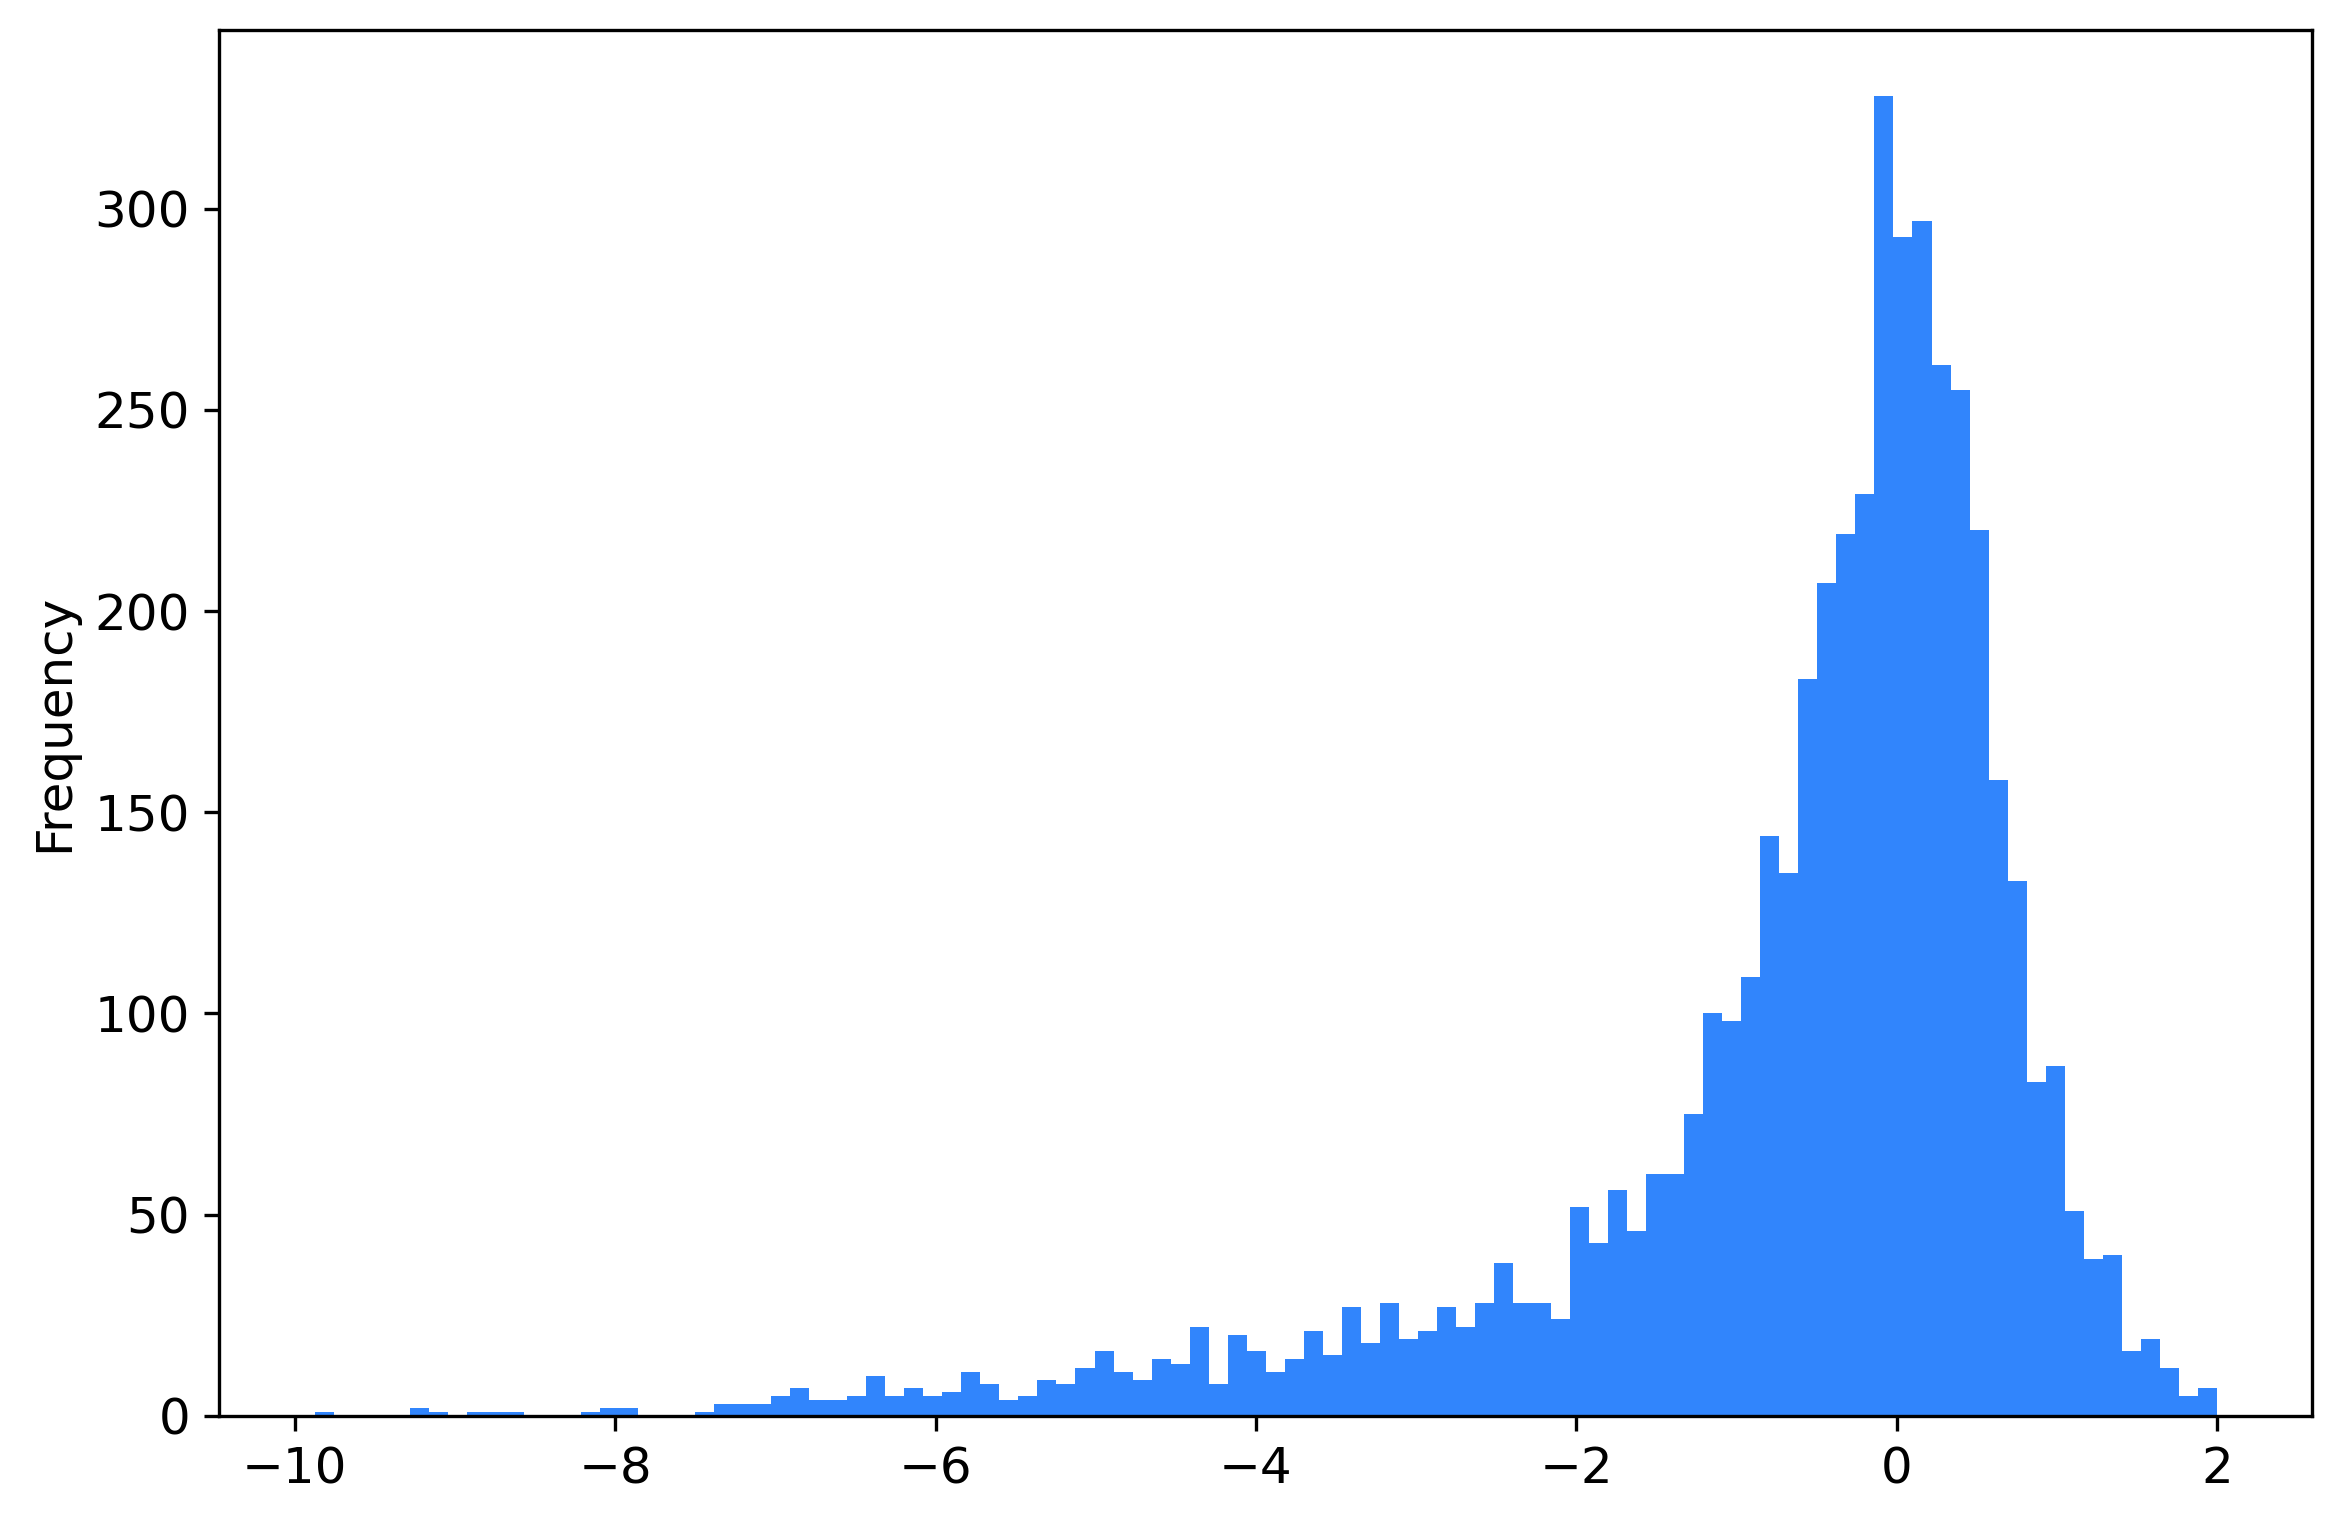

In [32]:
grps[1].plot.hist(bins=100)